In [1]:
import discretize
from SimPEG import (
    maps,
    utils,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    directives,
    inversion,
)
from SimPEG.electromagnetics.static import resistivity as DC, utils as DCutils
import numpy as np
import time
import matplotlib.pyplot as plt
from pymatsolver import Pardiso as Solver

%pylab inline


Populating the interactive namespace from numpy and matplotlib


15616


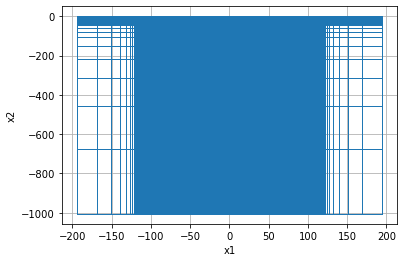

In [2]:
### mesh

# Cell sizes
csx, csz = 1.0, 0.5

# Number of core cells in each direction
ncx, ncz = 240, 45

# Number of padding cells to add in each direction
npadx = 8
npadz = 16

# Vectors of cell lengths in each direction with padding
hx = [(csx, npadx, -1.5), (csx, ncx), (csx, npadx, 1.5)]
hz = [(csz, npadz, -1.5), (csz, ncz)]

# Create mesh and center it
mesh = discretize.TensorMesh([hx, hz],x0="CN")

mesh.plotGrid()

print(mesh.nC)

In [3]:
### model

# background
mtrue = np.ones(mesh.nC) * 10**1.5

# conductive sphere
x0, z0, r0, rho0 = 0, -15, 7.0,10**-1
csph = (np.sqrt((mesh.gridCC[:, 0] - x0) ** 2.0
        + (mesh.gridCC[:, 1] - z0) ** 2.0)) < r0
mtrue[csph] = np.ones_like(mtrue[csph]) * rho0

# resistive layer
z1, rho1 = -2, 10**3
rlay = (mesh.gridCC[:, 1]) > z1
mtrue[rlay] = np.ones_like(mtrue[rlay]) * rho1

In [4]:
### survey & problem

IO = DC.IO()
xmin, xmax = -117.5,117.5
zmin, zmax = 0, 0
endl = np.array([[xmin, zmin], [xmax, zmax]])
survey = DCutils.generate_dcip_survey(endl, "dipole-dipole", dim=mesh.dim, a=5, b=5, n=10)
survey = IO.from_ambn_locations_to_survey(
    survey.locations_a,
    survey.locations_b,
    survey.locations_m,
    survey.locations_n,
    survey_type='dipole-dipole',
    data_dc_type="volt",
)

expmap = maps.ExpMap(mesh)
mapping = expmap 
problem = DC.Simulation2DCellCentered(
    mesh, survey=survey, rhoMap=mapping, solver=Solver, bc_type="Neumann"
)


E:\Personal2\Teddi\anaconda\envs\simpeg14\lib\site-packages\SimPEG\electromagnetics\static\resistivity\IODC.py:190: UserWarning: code under construction - API might change in the future
  warnings.warn("code under construction - API might change in the future")


97.7323494342355
100.45466760763279


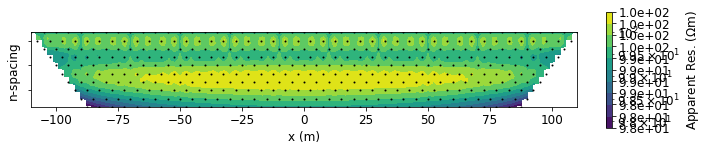

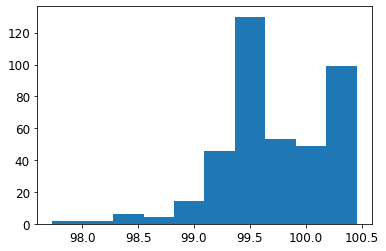

In [55]:
### test with homogeneous model

data_homo = problem.make_synthetic_data(log(ones(size(mtrue))*100), relative_error=0.0)

IO.plotPseudoSection(data=data_homo.dobs/IO.G, data_type="apparent_resistivity")

print(min(data_homo.dobs/IO.G))
print(max(data_homo.dobs/IO.G))

plt.figure()
plt.hist(data_homo.dobs/IO.G);

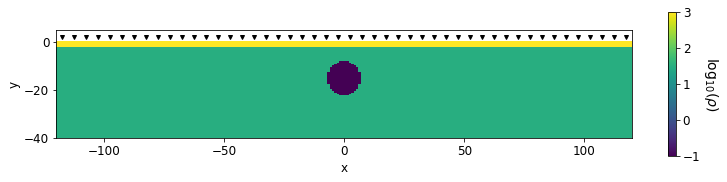

In [40]:
### plot model 

fig = plt.figure(figsize=(10,2))
ax = fig.add_axes([0,0,1,1],aspect='equal')   
dat = mesh.plotImage(log10(mtrue),ax=ax)
cbar = colorbar(dat[0])
cbar.set_label(r'log$_{10}$($\rho$)', rotation=270,labelpad=20,fontsize=14)
plt.ylim([-40,5])
plt.xlim([-120,120])
plt.plot(survey.electrode_locations.T[0],survey.electrode_locations.T[1]+2,'kv',markersize=4)

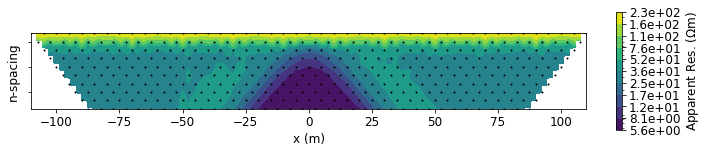

In [7]:
### plot data

data = problem.make_synthetic_data(log(mtrue), relative_error=0.03, add_noise=True)
IO.plotPseudoSection(data=data.dobs/IO.G, data_type="apparent_resistivity")

In [12]:
### inversion 

# reference model 
m0 = np.ones(mapping.nP)*np.log(mean(data.dobs/IO.G))

# data misfit
dmisfit = data_misfit.L2DataMisfit(simulation=problem, data=data)

# regularization mapping
regmap = maps.IdentityMap(nP=mesh.nC)

# inversion components
reg = regularization.Tikhonov(mesh, mapping=regmap)
opt = optimization.InexactGaussNewton(maxIter=10)
invProb = inverse_problem.BaseInvProblem(dmisfit, reg, opt) 
target = directives.TargetMisfit()
updateSensW = directives.UpdateSensitivityWeights()
update_Jacobi = directives.UpdatePreconditioner()    
start_time = time.time()
beta = directives.BetaEstimate_ByEig(beta0_ratio=1.)
betaSched = directives.BetaSchedule(coolingFactor=5., coolingRate=2)
inv = inversion.BaseInversion(invProb, directiveList=[updateSensW, beta, target, betaSched, update_Jacobi])

# run
mopt = inv.run(m0) 

jtj = np.sqrt(updateSensW.JtJdiag[0])
dpred = problem.dpred(mopt)
mpe = (mean(abs(data.dobs-dpred)/abs(data.dobs))*100)

print ('\r Time: {:.0f} mins'.format((time.time() - start_time)/60.))
 

SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.16e+03  1.20e+06  0.00e+00  1.20e+06    7.74e+04      0              
   1  3.16e+03  1.21e+05  1.09e+00  1.25e+05    9.98e+03      0              
   2  6.32e+02  2.63e+04  1.40e+00  2.72e+04    1.44e+03      0   Skip BFGS  
   3  6.32e+02  1.63e+04  2.52e+00  1.79e+04    6.09e+02      0   Skip BFGS  
   4  1.26e+02  1.52e+04  2.48e+00  1.55e+04    2.65e+02      0              
   5  1.26e+02  1.11e+04  1.16e+01  1.25e+04    3.93e+02      0              
   6  2.53e+01  8.25e+03  1.50e+01  8.63e+03    3.48e+02  

Text(0.5, 1.0, 'M$_{est}$')

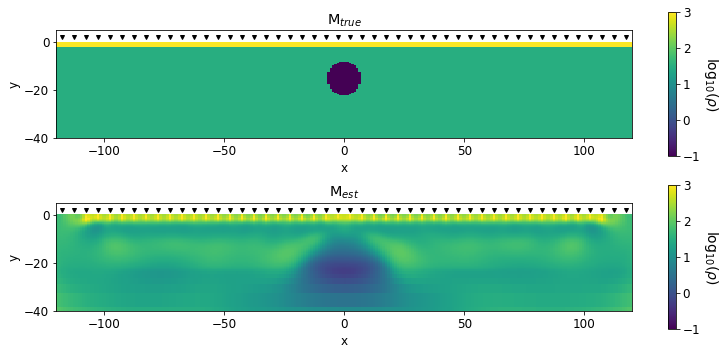

In [51]:
### plot estimated model

fig = plt.figure(figsize=(10,2))

ax = fig.add_axes([0,0,1,1],aspect='equal')   
dat = mesh.plotImage(log10(mtrue),ax=ax)
cbar = colorbar(dat[0])
cbar.set_label(r'log$_{10}$($\rho$)', rotation=270,labelpad=20,fontsize=14)
plt.ylim([-40,5])
plt.xlim([-120,120])
plt.plot(survey.electrode_locations.T[0],survey.electrode_locations.T[1]+2,'kv',markersize=4)
plt.title(r'M$_{true}$')

ax = fig.add_axes([0,-1.2,1,1],aspect='equal')   
dat = mesh.plotImage(log10(exp(mopt)),ax=ax,clim=[min(log10(mtrue)),max(log10(mtrue))])
cbar = colorbar(dat[0])
cbar.set_label(r'log$_{10}$($\rho$)', rotation=270,labelpad=20,fontsize=14)
plt.ylim([-40,5])
plt.xlim([-120,120])
plt.plot(survey.electrode_locations.T[0],survey.electrode_locations.T[1]+2,'kv',markersize=4)
plt.title(r'M$_{est}$')
